In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from random import choices, sample
from numpy import linalg as LA
from scipy.stats import norm
plt.style.use('dark_background')

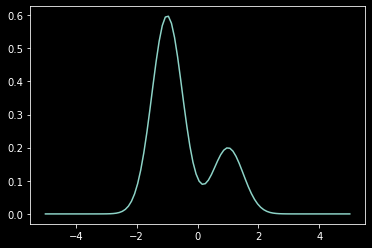

In [3]:
len = 10000
b1 = 0.5
b2 = 0.5
def target(x,b1,b2):
    return b1 * norm.pdf(x, loc = -1, scale = b2) + (1 - b1) * norm.pdf(x, loc = 1, scale = b2)
x = np.linspace(-5,5,100)
plt.plot(x,target(x,0.75,0.5))
def myMCMC(len):
    X = np.empty(len)
    acceptance = np.empty(len)
    X[0] = 0
    x_curr = 0
    acceptance[0] = 1
    for i in range(len-1):
        # Create candidate
        x_cand = np.random.normal(loc=x_curr,scale=1.0,size=1)
        # Acceptance probability
        alpha = min([1,target(x_cand,b1,b2)/target(x_curr,b1,b2)])
        if np.random.random() < alpha:
            X[i+1] = x_cand
            acceptance[i+1]=1
        else:
            X[i+1]=X[i]
            acceptance[i+1]=0
        x_curr = X[i+1]
    return X, acceptance

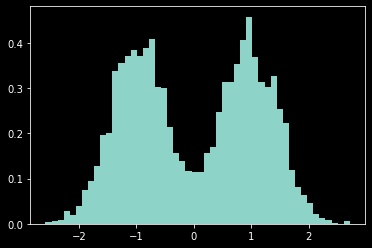

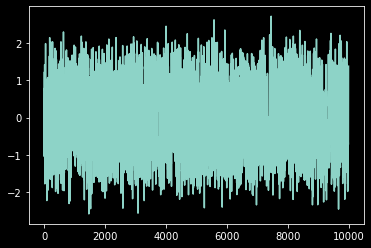

In [4]:
X,acceptance = myMCMC(len)
plt.hist(X, density = True, bins = 50)
plt.figure()
plt.plot(range(len),X)

(array([0.02079434, 0.02079434, 0.08317735, 0.16635469, 0.24953204,
        0.49906408, 0.29112072, 0.37429806, 0.08317735, 0.14556036,
        0.08317735, 0.06238301, 0.31191505, 0.43668107, 0.41588674,
        0.35350373, 0.27032638, 0.20794337, 0.04158867, 0.04158867]),
 array([-2.44610589, -2.20565581, -1.96520572, -1.72475564, -1.48430556,
        -1.24385548, -1.00340539, -0.76295531, -0.52250523, -0.28205515,
        -0.04160506,  0.19884502,  0.4392951 ,  0.67974518,  0.92019527,
         1.16064535,  1.40109543,  1.64154551,  1.8819956 ,  2.12244568,
         2.36289576]),
 <a list of 20 Patch objects>)

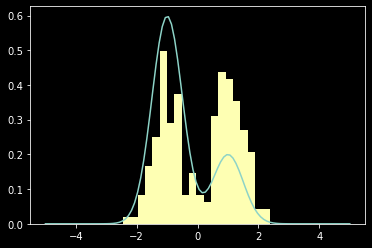

In [5]:
# Simulate multiple MCMCs
N = 200
len=50
chains=np.empty((len,N))
acceptance=np.empty((len,N))
for i in range(N):
    chains[:,i], acceptance[:,i] = myMCMC(len);

plt.figure()
plt.plot(x,target(x,0.75,0.5))
plt.hist(chains[len-1,:],bins = 20, density = True)

In [6]:
# Weight compensation for a specific perturbation
from scipy.integrate import simps
def reweighting(Db1):
    W=np.empty((len,N))
    W[0,:]=np.ones((1,N))
    
    quad_grid = np.linspace(-5,5,500)
    
    for j in range(N):
        for i in range(len-1):
            if acceptance[i+1,j]:
                alpha_mod = min([1, target(chains[i+1,j], b1 + Db1, b2)/target(chains[i,j],b1 + Db1, b2)])
                alpha = min([1, target(chains[i+1,j], b1, b2)/target(chains[i,j], b1, b2)])
                incr = alpha_mod/alpha
            else:
                igrand=target(quad_grid, b1, b2)/target(chains[i,j], b1, b2)
                igrand[igrand>1]=1
                
                igrand_mod = target(quad_grid, b1 + Db1, b2)/target(chains[i,j], b1 + Db1, b2)
                igrand_mod[igrand_mod>1]=1
                rej=1 - simps(igrand*norm.pdf(quad_grid, loc=chains[i,j], scale=1),quad_grid)
                rej_mod=1-simps(igrand_mod * norm.pdf(quad_grid, loc=chains[i,j],scale=1),quad_grid)
                incr=rej_mod/rej
            W[i+1,j] = W[i,j]*incr
#        display(\"Done\")
    return W               

In [7]:
# Effective sample size calculation
# ---------------------------------
def ess(W):
    normalisers = np.sum(W,axis=1)
    W = W/normalisers[:,np.newaxis]
    return 1/np.sum(W**2,axis=1), W

-0.45

-0.405

-0.36

-0.315

-0.27

-0.22500000000000003

-0.18

-0.135

-0.09000000000000002

-0.04500000000000004

-5.551115123125783e-17

0.044999999999999984

0.09000000000000002

0.13499999999999995

0.18

0.22499999999999992

0.26999999999999996

0.315

0.35999999999999993

0.40499999999999997

0.45

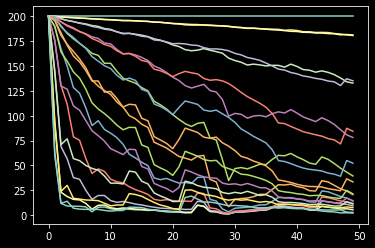

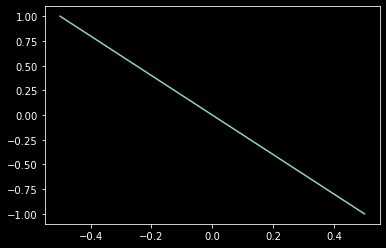

In [8]:
n_perturbs = 21
perturbations = np.linspace(-0.45,0.45,n_perturbs)
ESS=np.empty((len,n_perturbs))
x_hats=np.empty(n_perturbs)
column=0
plt.figure()
for p in perturbations:
    display(p)
    W = reweighting(p)
    ESS[:,column], W = ess(W)
    plt.plot(ESS[:,column])
    x_hats[column] = sum(W[len-1,:]*chains[len-1,:])
    column=column+1
plt.figure()
plt.plot([-.5,0.5],[1,-1])
#plt.plot(perturbations,x_hats) #,linestyle=\"None\",marker=\"o\"
# plt.plot(perturbations,x_hats,linestyle=\"None\",marker=\"o\")